In [1]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Define paths to your dataset
dataset_dir = r"D:\kanishka credentials\final year project\TM\new_dataset" # Replace with the actual path to your dataset
categories = ["normal_images", "abnormal_images"]  # Class labels

# Image size
IMG_SIZE = 224

# Function to load and preprocess the images
def load_images(dataset_dir, categories):
    images = []
    labels = []
    for idx, category in enumerate(categories):
        folder_path = os.path.join(dataset_dir, category)
        for img_name in os.listdir(folder_path):
            try:
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize images
                img = img / 255.0  # Normalize images to [0, 1]
                images.append(img)
                labels.append(idx)  # 0 for normal, 1 for abnormal
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
    return np.array(images), np.array(labels)

# Load images and labels
X, y = load_images(dataset_dir, categories)

# Flatten the images to 1D (necessary for Isolation Forest)
X_flattened = X.reshape(X.shape[0], -1)

# Normalize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:
# Train the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(X_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# The prediction results are -1 for anomalies and 1 for normal points, so we need to map them
y_pred_train = [1 if label == 1 else 0 for label in y_pred_train]  # 1 for normal, 0 for abnormal
y_pred_test = [1 if label == 1 else 0 for label in y_pred_test]


In [5]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation on training data
print("Training Data Evaluation:")
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

# Evaluation on test data
print("Test Data Evaluation:")
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))


Training Data Evaluation:
[[  7 147]
 [ 32 200]]
              precision    recall  f1-score   support

           0       0.18      0.05      0.07       154
           1       0.58      0.86      0.69       232

    accuracy                           0.54       386
   macro avg       0.38      0.45      0.38       386
weighted avg       0.42      0.54      0.44       386

Test Data Evaluation:
[[ 2 42]
 [ 9 44]]
              precision    recall  f1-score   support

           0       0.18      0.05      0.07        44
           1       0.51      0.83      0.63        53

    accuracy                           0.47        97
   macro avg       0.35      0.44      0.35        97
weighted avg       0.36      0.47      0.38        97



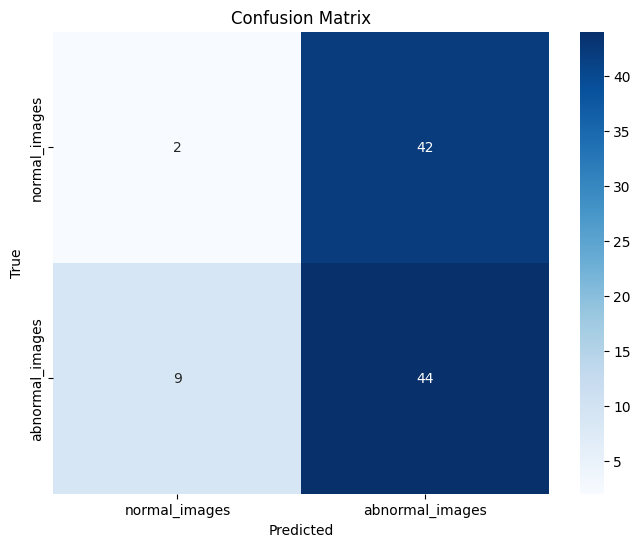

In [6]:
import seaborn as sns

# Confusion Matrix for Test Data
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


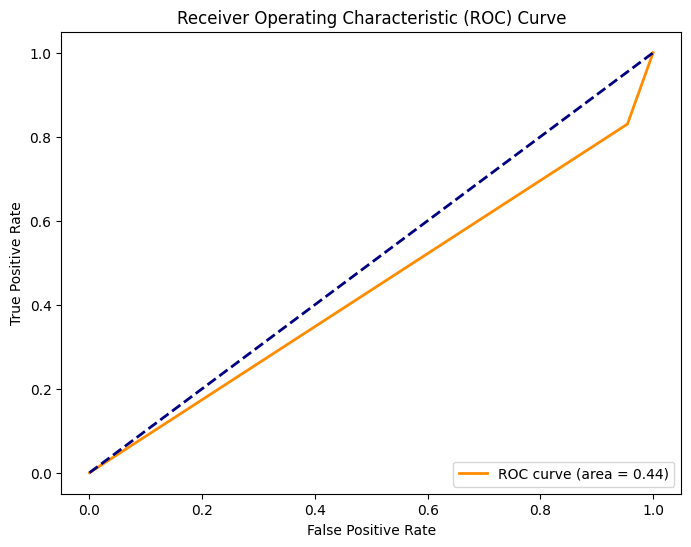

In [7]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


anamoly check and latency calculation

In [14]:
def preprocess_image(image_path, img_size=224):
    """
    Preprocess a single image for prediction with Isolation Forest model.
    - Resize the image to the target size.
    - Normalize the pixel values to [0, 1].
    """
    image_path= r"D:\kanishka credentials\final year project\TM\new_dataset\abnormal_images\1732118430275.png"
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))  # Resize image to the same size as training images
    img = img / 255.0  # Normalize the image to range [0, 1]
    img_flattened = img.reshape(1, -1)  # Flatten the image for the model (1, -1 means 1 row and flattened columns)
    return img_flattened

def measure_prediction_latency(image_path, model, scaler, img_size=224):
    # Preprocess the image
    processed_image = preprocess_image(image_path, img_size)
    
    # Apply scaling (same as during training)
    processed_image_scaled = scaler.transform(processed_image)
    
    # Measure the time before prediction
    start_time = time.time()
    
    # Make the prediction (this is the part we want to measure latency for)
    prediction = model.predict(processed_image_scaled)
    
    # Measure the time after prediction
    end_time = time.time()
    
    # Calculate the latency (time taken for the prediction)
    latency = end_time - start_time
    
    # Map prediction result to 'normal' or 'abnormal'
    predicted_class = "normal" if prediction == 1 else "abnormal"
    
    # Return both the prediction and the latency
    return predicted_class, latency


# Assuming you already have the trained 'model' and 'scaler'
predicted_class, latency = measure_prediction_latency(image_path, model, scaler)

# Print the result
print(f"The image is classified as: {predicted_class}")
print(f"Prediction latency: {latency:.4f} seconds")

The image is classified as: abnormal
Prediction latency: 0.0080 seconds


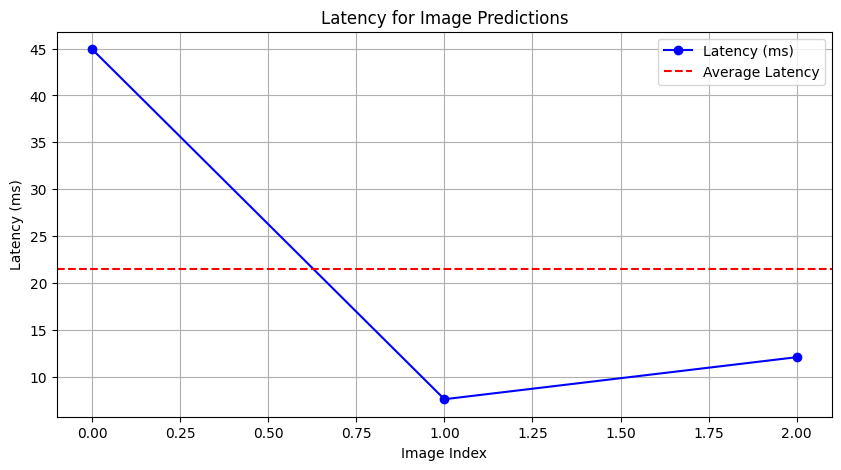

In [11]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to preprocess image
def preprocess_image(image_path, scaler):
    image_path=r"D:\kanishka credentials\final year project\TM\new_dataset\abnormal_images\1732118431300.png"
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image path does not exist: {image_path}")

    img = cv2.imread(image_path)  # Load image
    if img is None:
        raise ValueError(f"Unable to read the image: {image_path}")

    img = cv2.resize(img, (224, 224))  # Resize to required size
    img = img / 255.0  # Normalize pixel values
    img = img.flatten()  # Flatten for the Isolation Forest model
    return scaler.transform([img])  # Scale the data

# Function to measure prediction latency
def measure_prediction_latency(image_path, model, scaler):
    start_time = time.time()  # Start the timer
    preprocessed_img = preprocess_image(image_path, scaler)  # Preprocess image
    prediction = model.predict(preprocessed_img)  # Get prediction
    end_time = time.time()  # End the timer
    latency = (end_time - start_time) * 1000  # Convert to milliseconds
    return latency

# Paths to test images
image_paths = [
    r"D:\kanishka credentials\final year project\TM\new_dataset\abnormal_images\1732118431300.png",
    r"D:\kanishka credentials\final year project\TM\new_dataset\abnormal_images\1732118428226.png",
    r"D:\kanishka credentials\final year project\TM\new_dataset\abnormal_images\1732118429264.png",
    # Add more paths as needed
]

# Measure latencies for each image
latencies = []
for image_path in image_paths:
    try:
        latency = measure_prediction_latency(image_path, model, scaler)
        latencies.append(latency)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        latencies.append(None)

# Filter out None values before plotting
valid_latencies = [lat for lat in latencies if lat is not None]

# Plot the latency
plt.figure(figsize=(10, 5))
plt.plot(range(len(valid_latencies)), valid_latencies, marker='o', linestyle='-', color='b', label="Latency (ms)")
plt.axhline(np.mean(valid_latencies), color='r', linestyle='--', label="Average Latency")
plt.title("Latency for Image Predictions")
plt.xlabel("Image Index")
plt.ylabel("Latency (ms)")
plt.legend()
plt.grid()
plt.show()
